In [1]:
%matplotlib notebook 

import numpy
import scipy.optimize
import matplotlib.pyplot as plot

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [3]:
numpy.random.seed(1234)

In [4]:
# data set generation
n_dim = 2

n_mean1 = numpy.array([-1., -1.])
n_cov1 = numpy.diag([0.5, .5])
n_mean2 = numpy.array([1., 1.])
n_cov2 = numpy.diag([0.5, .5])

p_mean1 = numpy.array([-1., 1.])
p_cov1 = numpy.diag([.5, .5])
p_mean2 = numpy.array([1., -1.])
p_cov2 = numpy.diag([.5, .5])

# generate postive examples
n_pos = 50
pos_y = numpy.ones(n_pos * 2) 
pos_x = numpy.concatenate([numpy.random.randn(n_pos, n_dim) * numpy.diag(p_cov1)[None, :] + p_mean1[None,:],
                           numpy.random.randn(n_pos, n_dim) * numpy.diag(p_cov2)[None, :] + p_mean2[None,:]])
n_pos *= 2
# generate negative examples
n_neg = 50
neg_y = numpy.zeros(n_neg * 2) 
neg_x = numpy.concatenate([numpy.random.randn(n_neg, n_dim) * numpy.diag(n_cov1)[None, :] + n_mean1[None,:],
                           numpy.random.randn(n_neg, n_dim) * numpy.diag(n_cov2)[None, :] + n_mean2[None,:]])
n_neg *= 2
# combine them
y = numpy.concatenate([pos_y, neg_y])
x = numpy.concatenate([pos_x, neg_x], axis=0)
# shuffle them
si = numpy.random.permutation(n_pos + n_neg)
y = y[si]
x = x[si]

# grab training examples
n_tra = numpy.round(0.5 * (n_pos + n_neg)).astype(numpy.int)

y_tra = y[:n_tra]
x_tra = x[:n_tra]

y_tes = y[n_tra:]
x_tes = x[n_tra:]

In [5]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [6]:
def rbf(x, bases, width=1.):
    return numpy.exp(-(((x[:,None,:] - bases[None,:,:]) ** 2).sum(-1) / width))

In [7]:
def logreg(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return sigmoid(y)

In [8]:
def logreg_dist(y, x, w, avg=False):
    y_ = logreg(x, w)
    
    d = -(y * numpy.log(y_ + 1e-12) + (1. - y) * numpy.log(1-y_ + 1e-12))
    
    if not avg:
        return d
    return numpy.mean(d)

In [12]:
def logreg_rule(y, x, w):
    y_ = logreg(x, w)
    dw = numpy.zeros(w.shape)
    dw[:-1] = numpy.mean((y_tra - y_)[:, None] * x, axis=0)
    dw[-1] = numpy.mean(y_tra - y_)
    return dw

In [13]:
def _logreg_dist(w, x, y, avg=False):
    return logreg_dist(y, x, w, avg=avg), -logreg_rule(y, x, w)

In [14]:
n_bases = 25
# select random centroids
cids = numpy.random.permutation(len(x_tra))[:n_bases]
centroids = x_tra[cids]
x_tra_ = rbf(x_tra, centroids, 1.)

w0 = numpy.random.randn(n_bases+1); w0[-1] = 0.
w = numpy.copy(w0)

res = scipy.optimize.minimize(_logreg_dist, w0, (x_tra_, y_tra, False), method='L-BFGS-B', jac=True)

In [15]:
print res
w = res.x

      fun: array([  1.06835782e-05,   1.98695633e-05,   2.71099185e-03,
         1.86114335e-07,   7.72218646e-02,   6.92719727e-08,
         2.45246033e-02,   6.28027404e-03,   2.09894817e-05,
         3.81068098e+00,   2.03868938e-07,   5.95261029e-03,
         1.31587986e-02,   1.11597031e-05,   5.00963071e-03,
         1.53862639e-02,   1.42365095e-03,   2.11049522e-01,
         1.84921696e-03,   6.36675864e-01,   3.77181921e-03,
         8.34853667e-02,   7.16238437e-01,   3.48550621e-04,
         1.93575431e-03,   9.84033394e-01,   5.57825054e-02,
         9.38317604e-06,   2.30163205e+00,   3.00193820e-03,
         4.94347725e-03,   2.30663053e-02,   6.14415746e-01,
         3.60966886e-01,   5.23272001e-01,   9.48902665e-01,
         2.22099467e-04,   6.04273626e-03,   2.68522018e-04,
         3.32514602e-02,   1.21900844e-02,   5.29004797e-05,
         2.17224790e-01,   7.12685017e-07,   1.31878529e-01,
         5.57730408e-02,   6.42754515e-05,   2.39745463e-03,
         3.11

In [16]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [17]:
def vis_decision_boundary(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    x_tra_ = rbf(numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1), centroids, 1.)
    
    pred = logreg(x_tra_, w)
    plt1 = plot.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

<IPython.core.display.Javascript object>


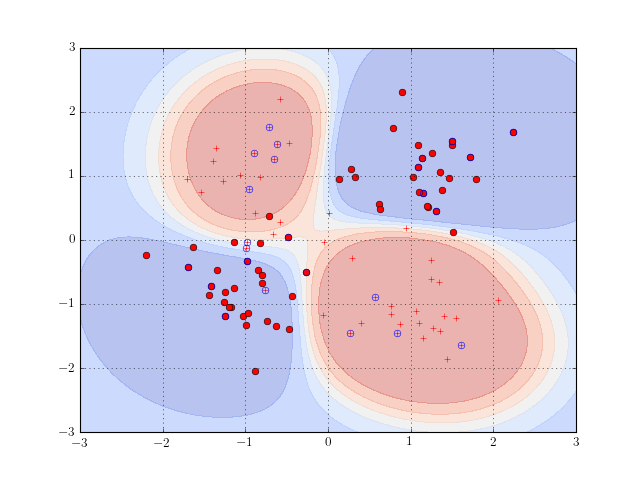

In [18]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
vis_data(centroids, None, c='b')

plt1 = vis_decision_boundary(w, 'k--')

plot.show()

In [19]:
x_tra_ = rbf(x_tra, centroids, 1.)
x_tes_ = rbf(x_tes, centroids, 1.)

tra_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tra_, w)) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tes_, w)) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.07, Test error rate 0.06
